In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
os.chdir('/data7/brandon/research/DA_MVR/sil_consistent_at_inference')
import sys

import torch
from PIL import Image
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.transform import resize
from skimage import img_as_bool
from tqdm import tqdm
import glob
import pprint
import pickle

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftPhongShader
)

from plot_image_grid import image_grid

In [3]:
# based on https://github.com/facebookresearch/pytorch3d/issues/51
def load_untextured_mesh(mesh_path, device):
    mesh = load_objs_as_meshes([mesh_path], device=device, load_textures = False)
    verts, faces_idx, _ = load_obj(mesh_path)
    faces = faces_idx.verts_idx
    verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
    textures = Textures(verts_rgb=verts_rgb.to(device))
    mesh_no_texture = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
        )
    return mesh_no_texture

In [4]:
def render_mesh(mesh, R, T, device):
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(
        image_size=512, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    lights = PointLights(device=device, location=[[0.0, 5.0, -10.0]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )

    rendered_images = renderer(mesh, cameras=cameras)
    return rendered_images

In [5]:
def crop_binary_mask(mask):
    # Get the height and width of bbox
    objs = ndimage.find_objects(mask)
    # upper left, lower right
    img_bbox = [objs[0][0].start, objs[0][1].start, objs[0][0].stop, objs[0][1].stop]
    # crop
    cropped_mask = mask[img_bbox[0]:img_bbox[2],img_bbox[1]:img_bbox[3] ]
    return cropped_mask

# return IOU, given an rgba 4-channel image and a mask. They don't need to be the same size
# (mask will be resized)
def get_iou(img, mask):
    img_mask = img[:,:,3] > 0
    mask_resized = img_as_bool(resize(mask, img_mask.shape))
    overlap = img_mask * mask_resized # Logical AND
    union = img_mask + mask_resized # Logical OR
    IOU = overlap.sum()/float(union.sum())
    return IOU

# given an 4 channel image (w1 x h1 x rgba), assumed to be an object on a white background and a mask (w2 x h2 x 1)
# will crop the image and mask, resize them, and then compute the IoU
# (mask is the gt mask, img is rendered reconstruction)
def get_normalized_iou(img, mask, show_intermediate = False):
    img_mask = img[:,:,3] > 0
    img_mask_cropped = crop_binary_mask(img_mask)
    mask_cropped = crop_binary_mask(mask)
    # resize the image to the mask's dimensions
    img_mask_resized = img_as_bool(resize(img_mask_cropped, mask_cropped.shape))
    
    overlap = img_mask_resized*mask_cropped # Logical AND
    union = img_mask_resized + mask_cropped # Logical OR
    IOU = overlap.sum()/float(union.sum())
    
    if show_intermediate:
        #plt.imshow(img_mask_cropped)
        #plt.show()
        plt.imshow(mask_cropped)
        plt.show()
        plt.imshow(img_mask_resized)
        plt.show()
    return IOU

# assumes input is an rgba image (np array); returns a boolean, of if the image contained in the image
# is captured fully (there is an empty border around the image.)
# pix_border_req is the threshold num. of pixels on the border to be considered "captured fully"
def rgba_obj_in_frame(rgba_img, px_border_req=1):
    mask = (rgba_img[:,:,3] > 0)
    objs = ndimage.find_objects(mask)
    # TODO: check height, width
    img_height = mask.shape[0]
    img_width = mask.shape[1]
    # upper left, lower right
    upper_left = [objs[0][0].start, objs[0][1].start]
    lower_right = [objs[0][0].stop, objs[0][1].stop]
    in_frame = False
    if (upper_left[0] >= px_border_req and upper_left[1] >= px_border_req and 
        img_width - lower_right[0] >= px_border_req and img_height - lower_right[1] >= px_border_req):
        in_frame = True
    
    return in_frame

In [6]:
# renders in batches
def batched_render(mesh, azims, elevs, dists, batch_size):
    meshes = mesh.extend(batch_size)
    num_renders = azims.shape[0]
    renders = []
    for batch_i in tqdm(range(int(np.ceil(num_renders/batch_size)))):
        pose_idx_start = batch_i * batch_size
        pose_idx_end = min((batch_i+1) * batch_size, num_renders)
        batch_azims = azims[pose_idx_start:pose_idx_end]
        batch_elevs = elevs[pose_idx_start:pose_idx_end]
        batch_dists = dists[pose_idx_start:pose_idx_end]
        
        R, T = look_at_view_transform(batch_dists, batch_elevs, batch_azims) 
        if batch_azims.shape[0] != batch_size:
            meshes = mesh.extend(batch_azims.shape[0])
        batch_renders = render_mesh(meshes, R, T, device)
        renders.append(batch_renders)
    renders = torch.cat(renders)
    return renders

# given a mesh and a mask, finds position of the camera by brute force
# there are two steps: 1) finding the azimuth and elevation and 2) find the distance
# the additional requirement that the entire mesh should fit in the image after rendered at the estimated pose is also enforced 
# (the distance chosen must satisfy this)
def brute_force_estimate_pose(mesh, mask, num_azims, num_elevs, num_dists, device, batch_size = 8):
    torch.cuda.set_device(device)
    with torch.no_grad():
        # rendering at many different azimuth and elevation combinations on a sphere
        num_renders = num_elevs * num_azims
        azims = torch.linspace(0, 360, num_azims).repeat(num_elevs)
        elevs = torch.repeat_interleave(torch.linspace(0, 180, num_elevs), num_azims) # TODO: also add underneath elevs
        dists = torch.ones(num_renders) * 2.7
        renders = batched_render(mesh, azims, elevs, dists, batch_size)
        # computing iou of mask and azimuth/elevation renders
        iou_calcs = []
        for i in range(renders.shape[0]):
            iou = get_normalized_iou(renders[i].cpu().numpy(), mask, False)
            iou_calcs.append(iou)
            #print("azim: {}, elev: {}, iou: {}".format(azims[i], elevs[i], iou))

        # selecting render pose with highest iou to find predicted azimuth and elevation
        iou_argsort = np.argsort(iou_calcs)[::-1]
        iou_highest_idx = iou_argsort[0]
        pred_azim = azims[iou_highest_idx]
        pred_elev = elevs[iou_highest_idx]
        #print("highest iou: {}, azim: {}, elev: {}".format(iou_calcs[iou_highest_idx], pred_azim, pred_elev))

        # interpolating between rendered distances to find best distance for predicted azimuth and elevation
        azims = torch.ones(num_dists) * pred_azim
        elevs = torch.ones(num_dists) * pred_elev
        dists = torch.linspace(0.5, 3, num_dists)
        renders = batched_render(mesh, azims, elevs, dists, batch_size)
        iou_calcs = []
        rendered_image_fits = []
        for i in range(renders.shape[0]):
            iou = get_iou(renders[i].cpu().numpy(), mask)
            iou_calcs.append(iou)
            rendered_image_fits.append(rgba_obj_in_frame(renders[i].cpu().numpy()))
        iou_argsort = np.argsort(iou_calcs)[::-1]
        rendered_image_fits = np.array(rendered_image_fits)[iou_argsort]
        # choose distance with highest iou, whose rendered image will fit completely in the frame
        i = 0
        while not rendered_image_fits[i]:
            i+=1
        pred_dist = dists[iou_argsort[i]]
        
    return pred_azim, pred_elev, pred_dist, renders

In [7]:
DATASET_PATH = "notebooks/test_dataset"

mesh_paths = sorted(glob.glob(os.path.join(DATASET_PATH, "*.obj")))
data_paths = []
for mesh_path in mesh_paths:
    instance_number = int(mesh_path.split('/')[-1][:2])
    instance_img_path = os.path.join(DATASET_PATH, "{:02d}_in.jpg".format(instance_number))
    instance_mask_path = os.path.join(DATASET_PATH, "00{:02d}.png".format(instance_number+1))
    data_paths.append({"mesh": mesh_path, "input_img": instance_img_path, "mask": instance_mask_path})


/data7/drone_machinelearning/anaconda3/envs/standard/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


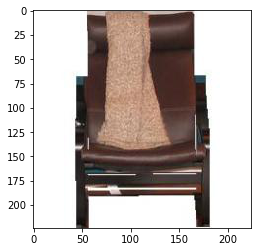

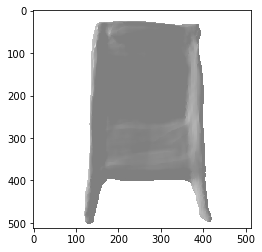

100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


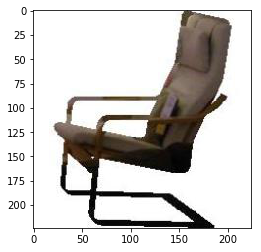

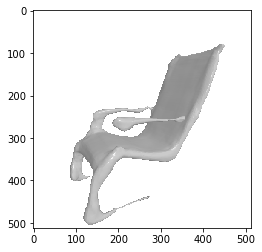

100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


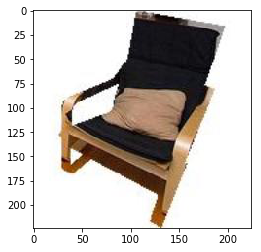

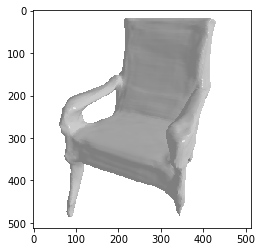

100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


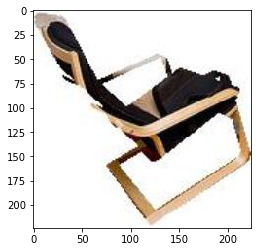

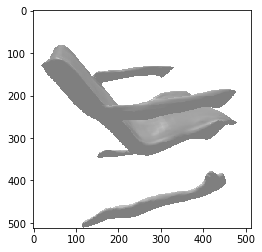

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


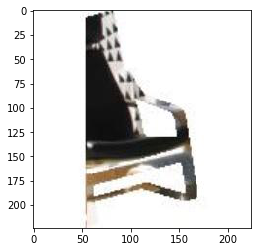

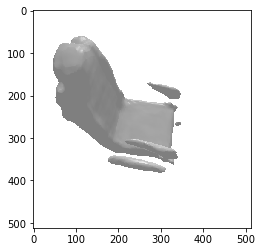

100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


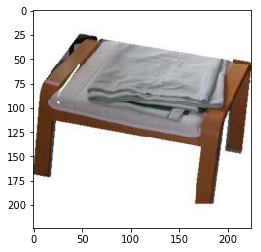

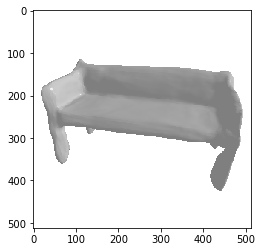

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


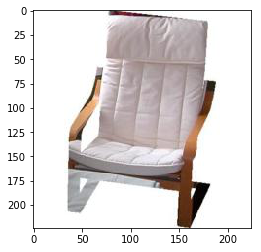

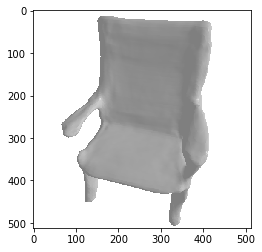

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


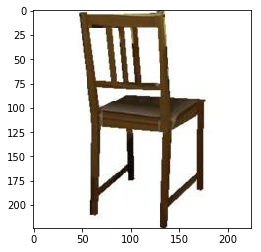

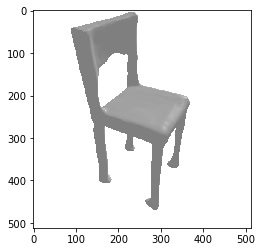

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


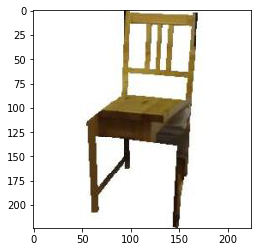

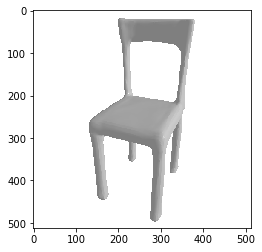

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


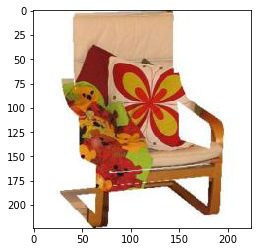

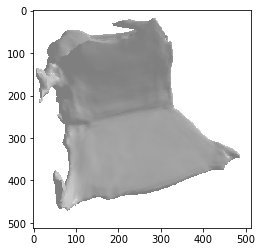

100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


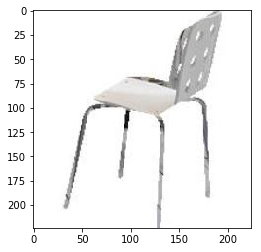

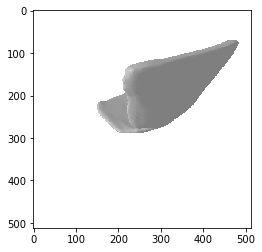

100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


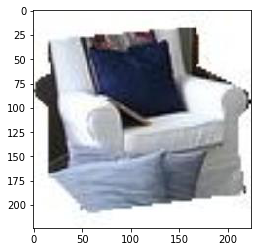

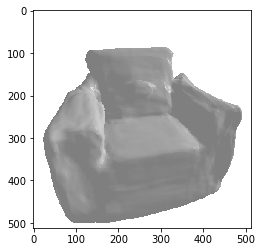

100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


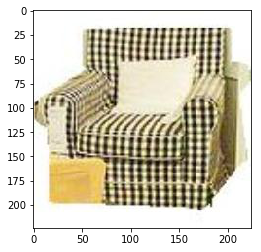

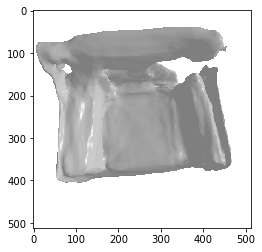

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


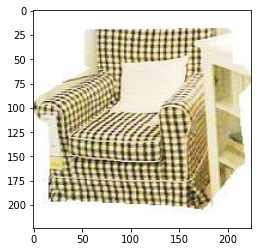

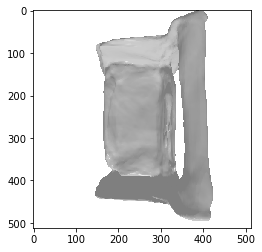

100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


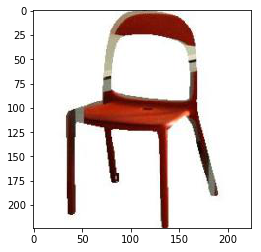

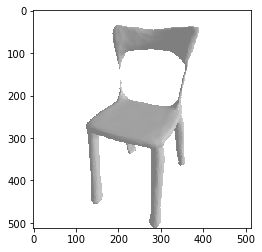

100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


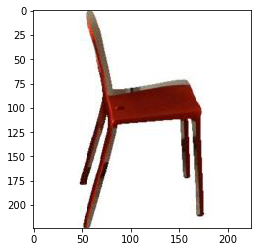

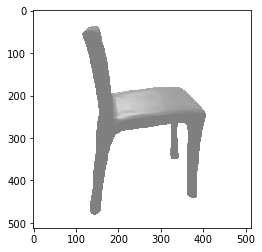

100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


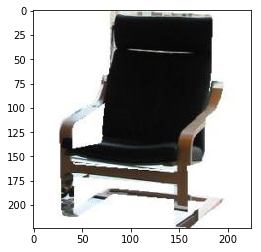

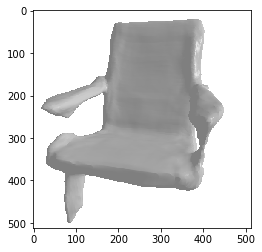

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


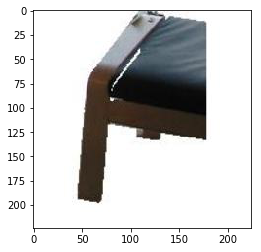

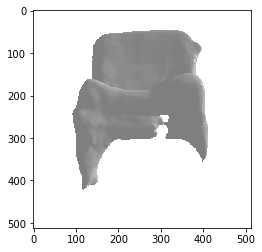

100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


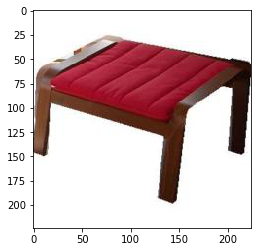

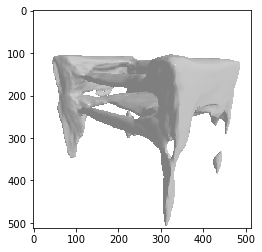

100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


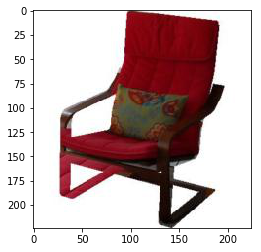

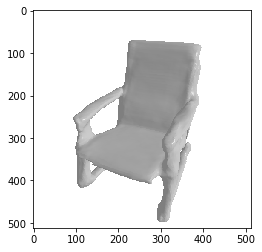

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


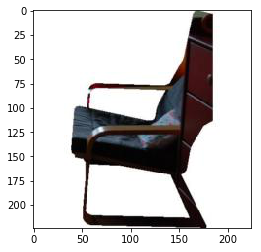

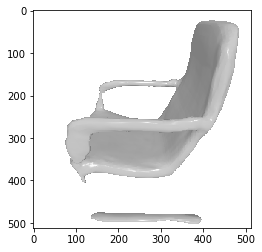

100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


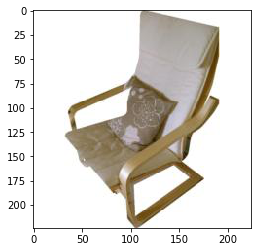

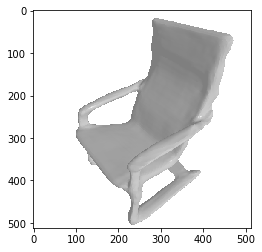

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


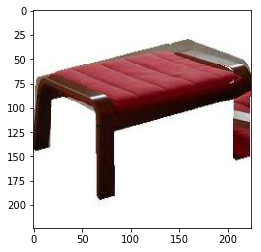

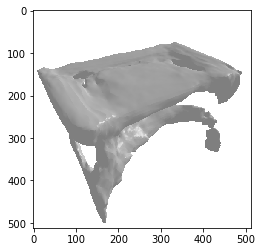

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


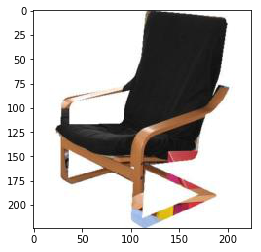

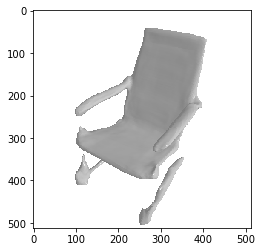

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


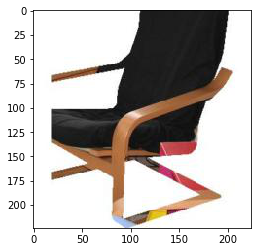

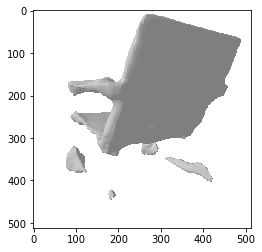

100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


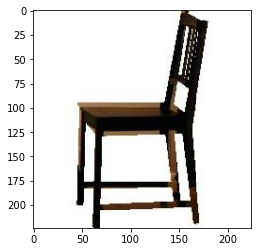

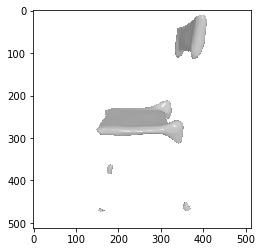

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


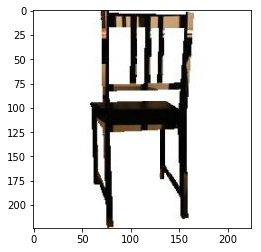

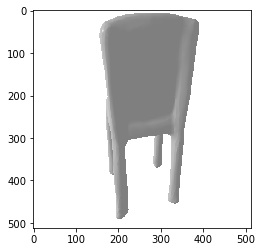

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


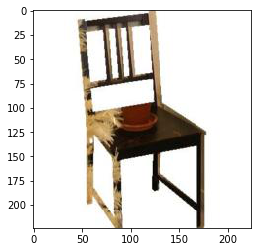

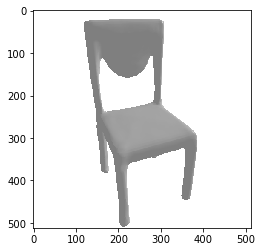

100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


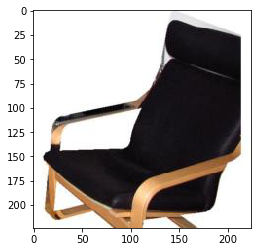

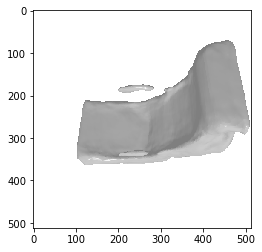

FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/test_dataset/0030.png'

In [8]:
device = torch.device("cuda:7")
cached_pred_poses = {}
for data in data_paths:
    input_image = np.asarray(Image.open(data['input_img']).convert('RGB'))
    with torch.no_grad():
        mesh = load_untextured_mesh(data['mesh'], device)
    # convert mask to 224 x 224 to match input image for nn
    mask = Image.open(data['mask']).resize((224,224))
    mask = np.asarray(mask)
    mask = (mask[:,:,3]> 0)
    
    # predicting pose
    pred_azim, pred_elev, pred_dist, renders = brute_force_estimate_pose(mesh, mask, 20, 20, 40, device, 8)
    #print("azim: {} elev: {} dist: {}".format(pred_azim, pred_elev, pred_dist))
    cached_pred_poses[data['input_img'].split('/')[-1]] = {"azim": pred_azim.item(), "elev": pred_elev.item(), "dist": pred_dist.item()}
    
    # showing results of pose prediction
    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 
    mesh_rendered_at_pred_pose = render_mesh(mesh, R, T, device)
    plt.imshow(input_image)
    plt.show()
    plt.imshow(mesh_rendered_at_pred_pose[0, ..., :3].cpu().numpy())
    plt.show()
    
    
    

In [9]:
pprint.pprint(cached_pred_poses)

{'00_in.jpg': {'azim': 265.2631530761719,
               'dist': 1.2051281929016113,
               'elev': 0.0},
 '01_in.jpg': {'azim': 151.57894897460938,
               'dist': 1.269230842590332,
               'elev': 9.473684310913086},
 '02_in.jpg': {'azim': 113.68421173095703,
               'dist': 1.076923131942749,
               'elev': 28.421052932739258},
 '03_in.jpg': {'azim': 341.0526428222656,
               'dist': 1.1410256624221802,
               'elev': 28.421052932739258},
 '04_in.jpg': {'azim': 189.47369384765625,
               'dist': 1.1410256624221802,
               'elev': 113.68421173095703},
 '05_in.jpg': {'azim': 284.2105407714844,
               'dist': 1.1410256624221802,
               'elev': 151.57894897460938},
 '06_in.jpg': {'azim': 284.2105407714844,
               'dist': 1.1410256624221802,
               'elev': 142.1052703857422},
 '07_in.jpg': {'azim': 208.42105102539062,
               'dist': 1.076923131942749,
               'elev': 142.1

In [17]:

pickle.dump(cached_pred_poses, open("notebooks/test_dataset_cached_pred_poses.p","wb"))

In [18]:


loaded_file = pickle.load(open("notebooks/test_dataset_cached_pred_poses.p", "rb"))
pprint.pprint(loaded_file)

{'00_in.jpg': {'azim': 265.2631530761719,
               'dist': 1.2051281929016113,
               'elev': 0.0},
 '01_in.jpg': {'azim': 151.57894897460938,
               'dist': 1.269230842590332,
               'elev': 9.473684310913086},
 '02_in.jpg': {'azim': 113.68421173095703,
               'dist': 1.076923131942749,
               'elev': 28.421052932739258},
 '03_in.jpg': {'azim': 341.0526428222656,
               'dist': 1.1410256624221802,
               'elev': 28.421052932739258},
 '04_in.jpg': {'azim': 189.47369384765625,
               'dist': 1.1410256624221802,
               'elev': 113.68421173095703},
 '05_in.jpg': {'azim': 284.2105407714844,
               'dist': 1.1410256624221802,
               'elev': 151.57894897460938},
 '06_in.jpg': {'azim': 284.2105407714844,
               'dist': 1.1410256624221802,
               'elev': 142.1052703857422},
 '07_in.jpg': {'azim': 208.42105102539062,
               'dist': 1.076923131942749,
               'elev': 142.1